In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function, absolute_import

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

# Using the Model to Make Predictions 

First, let's locate the latest model: It's called ```saved_model.pb```.

In [4]:
from temp_dir import temp_dir
import os
model_dir = os.path.join(temp_dir, "models/export/exporter")
versions = !ls $model_dir
print( "Versions: %s" % versions)
latest_version = max(versions)
latest_model = os.path.join(model_dir, str(latest_version))
!echo $latest_model
!ls $latest_model

Versions: ['1558472004', '1558472006']
/tmp/tmpqmz6u8ab/models/export/exporter/1558472006
saved_model.pb	variables


Create an estimator from that model:

In [5]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmpqmz6u8ab/models/export/exporter/1558472006/variables/variables


Use it to predict the humidity for a single record:

In [6]:
sample = {
    'beta1': [[1.234],[1.234]],
    'beta2': [[1.234],[1.234]],
    'weekday': [[5], [6]],
    'hour': [[16], [17]]
}

In [7]:
estimator(sample)

{'output': array([[28.209309],
        [20.447727]], dtype=float32)}

### Verifying prediction quality against the test set

In [8]:
!ls $temp_dir

eval.tfr-00000-of-00001  signature_eval.csv   tftransform_tmp
metadata		 signature_test.csv   training.csv-00000-of-00001
models			 signature_train.csv  training.tfr-00000-of-00001


In [9]:
test_data = pd.read_csv(os.path.join(temp_dir, "signature_test.csv"))
test_data.head()

,beta1,beta2,hour,humidity,weekday
0,-4.090830,-1.663895,9,12.308736,4
1,-0.850421,-0.978957,16,19.165211,2
2,-3.764737,0.685349,14,10.971267,3
3,-2.211652,0.004834,8,15.046182,5
4,-3.607233,-0.958197,11,12.537685,6


In [10]:
test_dict = test_data.drop('humidity', axis=1).to_dict(orient='list')
test_dict = { key: np.reshape(item, [-1,1]) for key, item in test_dict.items()}

In [11]:
predicted = estimator(test_dict)
len(predicted['output'])

20000

In [12]:
test_data['predicted'] = predicted['output'].reshape(-1)

In [13]:
test_data.head()

,beta1,beta2,hour,humidity,weekday,predicted
0,-4.090830,-1.663895,9,12.308736,4,11.114373
1,-0.850421,-0.978957,16,19.165211,2,17.128784
2,-3.764737,0.685349,14,10.971267,3,10.534496
3,-2.211652,0.004834,8,15.046182,5,14.022901
4,-3.607233,-0.958197,11,12.537685,6,11.824031


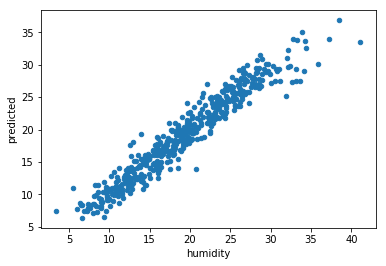

In [14]:
%matplotlib inline
test_data[:500].plot.scatter(x='humidity', y='predicted');

Our prediction strongly correlates with the measured humidity.

In [15]:
test_data['diff'] = test_data['humidity'] - test_data['predicted']

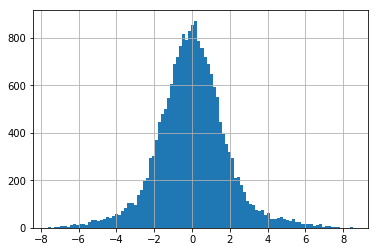

In [16]:
test_data['diff'].hist(bins=100);

And also, the error distribution is truly convincing. The remaining error is almost perfectly Gaussian.

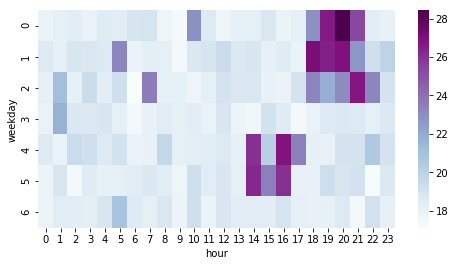

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
sns.heatmap(test_data.pivot_table(
    index='weekday', columns='hour', 
    values='predicted', aggfunc='mean'), cmap='BuPu');

The heatmap of predictions, averaged over $\beta_1$ and $\beta_2$ clearly shows that the model has figured out the anomaly that can be observed Mon-Wed between 18:00 and 21:00 and Fri-Sat between 14:00 and 16:00 hours.